# Проектная работа: Автоматизация

## Описание проекта

Вы работаете аналитиком в Яндекс.Дзене. Почти всё ваше время занимает анализ пользовательского взаимодействия с карточками статей.
Каждую карточку определяют её тема и источник (у него тоже есть тема). Примеры тем: «Красота и здоровье», «Россия», «Путешествия».
Пользователей системы характеризует возрастная категория. Скажем, «26-30» или «45+».
Есть три способа взаимодействия пользователей с системой:

    Карточка отображена для пользователя (show);
    Пользователь кликнул на карточку (click);
    Пользователь просмотрел статью карточки (view).

Каждую неделю начинающие менеджеры Денис и Валерия задают вам одни и те же вопросы: 

    Сколько взаимодействий пользователей с карточками происходит в системе с разбивкой по темам карточек?
    Как много карточек генерируют источники с разными темами?
    Как соотносятся темы карточек и темы источников?

На шестую неделю работы вы решаете, что процесс пора автоматизировать. Для Дениса и Валерии нужно сделать дашборд.
Дашборд будет основываться на пайплайне, который будет брать данные из таблицы, в которых хранятся сырые данные, трансформировать данные и укладывать их в агрегирующую таблицу. Пайплайн будет разработан для вас дата-инженерами.

только в конце писать код.
Пообщавшись с менеджерами и администраторами баз данных, вы написали краткое ТЗ:

    Бизнес-задача: анализ взаимодействия пользователей с карточками Яндекс.Дзен;
    Насколько часто предполагается пользоваться дашбордом: не реже, чем раз в неделю;
    Кто будет основным пользователем дашборда: менеджеры по анализу контента;
    Состав данных для дашборда:
      
        История событий по темам карточек (два графика - абсолютные числа и процентное соотношение);
        Разбивка событий по темам источников;
        Таблица соответствия тем источников темам карточек;
    По каким параметрам данные должны группироваться:
      
        Дата и время;
        Тема карточки;
        Тема источника;
        Возрастная группа;
    Характер данных:
      
        История событий по темам карточек — абсолютные величины с разбивкой по минутам;
        Разбивка событий по темам источников — относительные величины (% событий);
        Соответствия тем источников темам карточек - абсолютные величины;
    Важность: все графики имеют равную важность;
    Источники данных для дашборда: дата-инженеры обещали подготовить для вас агрегирующую таблицу dash_visits. Вот её структура:
      
        record_id  — первичный ключ,
        item_topic — тема карточки,
        source_topic — тема источника,
        age_segment — возрастной сегмент,
        dt — дата и время,
        visits — количество событий.
    Таблица хранится в специально подготовленной для вас базе данных zen;
    Частота обновления данных: один раз в сутки, в полночь по UTC;
    Какие графики должны отображаться и в каком порядке, какие элементы управления должны быть на дашборде (макет дашборда):

In [12]:
from IPython.display import Image # Библиотека для отображения картинок

display(Image(url='https://pictures.s3.yandex.net/resources/Untitled_-_2020-07-06T160925.436_1594041010.png', 
              width = 1000)  # Задаем ширину картинки
       )

# Выполнение работы

## Получение БД

In [2]:


#!/usr/bin/python
# -*- coding: utf-8 -*-

# импортируем библиотеки
import pandas as pd
from sqlalchemy import create_engine

db_config = {'user': 'praktikum_student', # имя пользователя
            'pwd': 'Sdf4$2;d-d30pp', # пароль
            'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
            'port': 6432, # порт подключения
            'db': 'data-analyst-zen-project-db'} # название базы данных

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(db_config['user'],
                                                db_config['pwd'],
                                                db_config['host'],
                                                db_config['port'],
                                                db_config['db'])

engine = create_engine(connection_string)

query = ''' SELECT *
            FROM dash_visits
        '''

dash_visits = pd.io.sql.read_sql(query, con = engine)



In [3]:
dash_visits

,record_id,item_topic,source_topic,age_segment,dt,visits
0,1040597,Деньги,Авто,18-25,2019-09-24 18:32:00,3
1,1040598,Деньги,Авто,18-25,2019-09-24 18:35:00,1
2,1040599,Деньги,Авто,18-25,2019-09-24 18:54:00,4
3,1040600,Деньги,Авто,18-25,2019-09-24 18:55:00,17
4,1040601,Деньги,Авто,18-25,2019-09-24 18:56:00,27
...,...,...,...,...,...,...
30740,1071337,Юмор,Финансы,36-40,2019-09-24 18:57:00,2
30741,1071338,Юмор,Финансы,36-40,2019-09-24 19:00:00,1
30742,1071339,Юмор,Финансы,41-45,2019-09-24 18:54:00,1
30743,1071340,Юмор,Финансы,41-45,2019-09-24 18:56:00,1


Данные успешно получены, самое время их изучить и заняться предобработкой

## Изучение БД

In [13]:
dash_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30745 entries, 0 to 30744
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   record_id     30745 non-null  int64         
 1   item_topic    30745 non-null  object        
 2   source_topic  30745 non-null  object        
 3   age_segment   30745 non-null  object        
 4   dt            30745 non-null  datetime64[ns]
 5   visits        30745 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 1.4+ MB


После получение информации о датафрейме можно сделать несколько выводов:
 1) в данных нет пропусков <br>
 2) типы данных выгружены правильно и соответствуют необходимым

In [23]:
print ('В датафрейме dash_visits полных дубликатов:', dash_visits.duplicated().sum())

В датафрейме dash_visits полных дубликатов: 0


In [28]:
print ('В датафрейме dash_visits предоставленны такие темы карточки как:', dash_visits.item_topic.unique())

В датафрейме dash_visits предоставленны такие темы карточки как: ['Деньги' 'Дети' 'Женская психология' 'Женщины' 'Здоровье' 'Знаменитости'
 'Интересные факты' 'Искусство' 'История' 'Красота' 'Культура' 'Наука'
 'Общество' 'Отношения' 'Подборки' 'Полезные советы' 'Психология'
 'Путешествия' 'Рассказы' 'Россия' 'Семья' 'Скандалы' 'Туризм' 'Шоу'
 'Юмор']


In [31]:
dash_visits.item_topic.value_counts()

Отношения             1536
Интересные факты      1535
Наука                 1505
Подборки              1456
Полезные советы       1424
Общество              1422
Россия                1385
История               1363
Семья                 1287
Путешествия           1247
Деньги                1234
Женщины               1230
Дети                  1229
Туризм                1206
Здоровье              1203
Красота               1193
Культура              1160
Юмор                  1129
Искусство             1119
Рассказы              1109
Психология            1056
Скандалы              1023
Знаменитости           976
Женская психология     914
Шоу                    804
Name: item_topic, dtype: int64

In [33]:
print ('В датафрейме dash_visits предоставленны такие источники тем как:', dash_visits.source_topic.unique())

В датафрейме dash_visits предоставленны такие источники тем как: ['Авто' 'Деньги' 'Дети' 'Еда' 'Здоровье' 'Знаменитости' 'Интерьеры'
 'Искусство' 'История' 'Кино' 'Музыка' 'Одежда' 'Полезные советы'
 'Политика' 'Психология' 'Путешествия' 'Ремонт' 'Россия' 'Сад и дача'
 'Сделай сам' 'Семейные отношения' 'Семья' 'Спорт' 'Строительство'
 'Технологии' 'Финансы']


In [32]:
dash_visits.source_topic.value_counts()

Семейные отношения    1822
Россия                1687
Знаменитости          1650
Полезные советы       1578
Путешествия           1563
Кино                  1505
Дети                  1459
История               1437
Семья                 1405
Одежда                1379
Здоровье              1243
Искусство             1228
Авто                  1077
Психология            1055
Сад и дача            1036
Политика              1024
Спорт                 1007
Сделай сам             995
Ремонт                 985
Деньги                 973
Еда                    912
Интерьеры              809
Строительство          758
Музыка                 750
Технологии             741
Финансы                667
Name: source_topic, dtype: int64

In [34]:
print ('В датафрейме dash_visits предоставленны такие возрастные категории как:', dash_visits.age_segment.unique())

В датафрейме dash_visits предоставленны такие возрастные категории как: ['18-25' '26-30' '31-35' '36-40' '41-45' '45+']


In [35]:
dash_visits.age_segment.value_counts()

18-25    7056
26-30    5875
31-35    5552
36-40    5105
41-45    3903
45+      3254
Name: age_segment, dtype: int64

In [37]:
dash_visits.dt.sort_values().unique()

array(['2019-09-24T18:28:00.000000000', '2019-09-24T18:29:00.000000000',
       '2019-09-24T18:30:00.000000000', '2019-09-24T18:31:00.000000000',
       '2019-09-24T18:32:00.000000000', '2019-09-24T18:33:00.000000000',
       '2019-09-24T18:34:00.000000000', '2019-09-24T18:35:00.000000000',
       '2019-09-24T18:52:00.000000000', '2019-09-24T18:53:00.000000000',
       '2019-09-24T18:54:00.000000000', '2019-09-24T18:55:00.000000000',
       '2019-09-24T18:56:00.000000000', '2019-09-24T18:57:00.000000000',
       '2019-09-24T18:58:00.000000000', '2019-09-24T18:59:00.000000000',
       '2019-09-24T19:00:00.000000000'], dtype='datetime64[ns]')

В датафрейме предоставлены данные с 2019-09-24 18:28:00 по 2019-09-24 18:59:00. Это всего больше получаса.

Рассмотрим количество событий

In [20]:
dash_visits.visits.describe()

count    30745.000000
mean        10.089673
std         19.727601
min          1.000000
25%          1.000000
50%          3.000000
75%         10.000000
max        371.000000
Name: visits, dtype: float64

<AxesSubplot:>

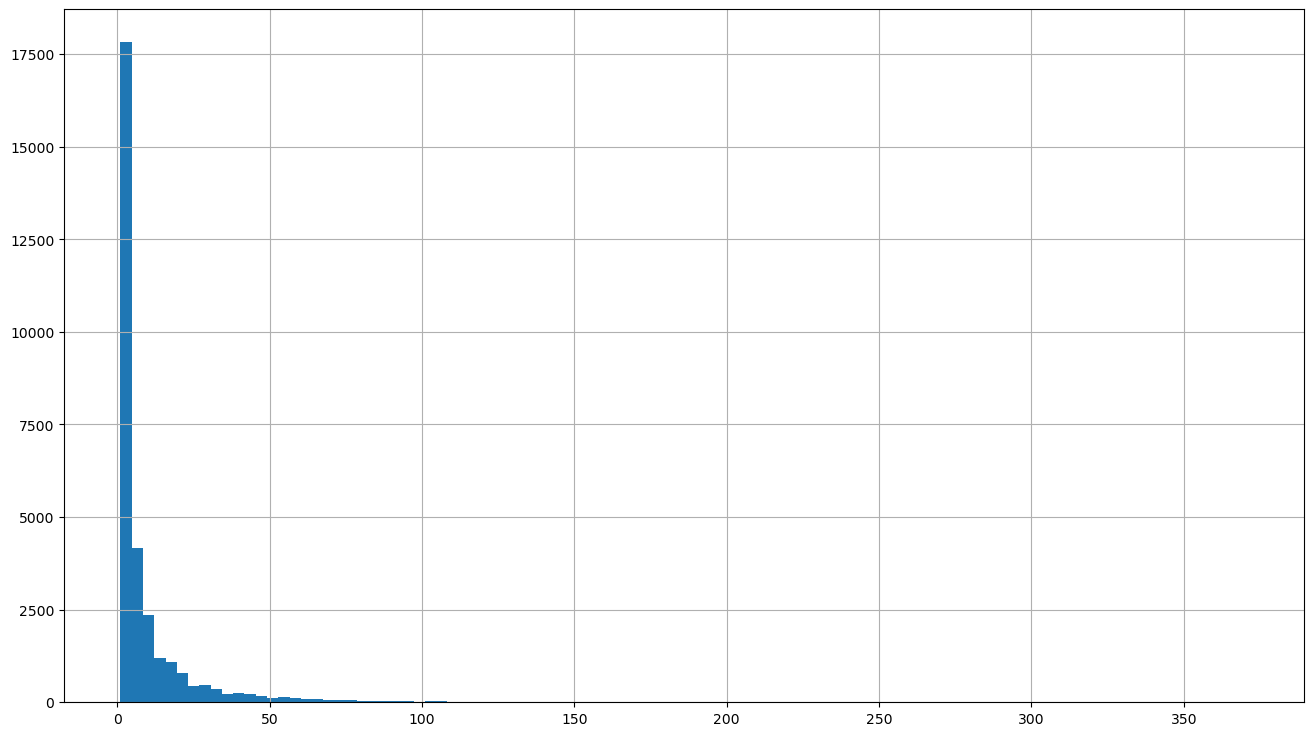

In [47]:
dash_visits.visits.hist(bins=100, figsize=(16,9))

Насколько мы видим распределение скошено. Также можно заметить большой хвост, который тянется вправо. Рассмотри этот хвост поподробнее.

<AxesSubplot:>

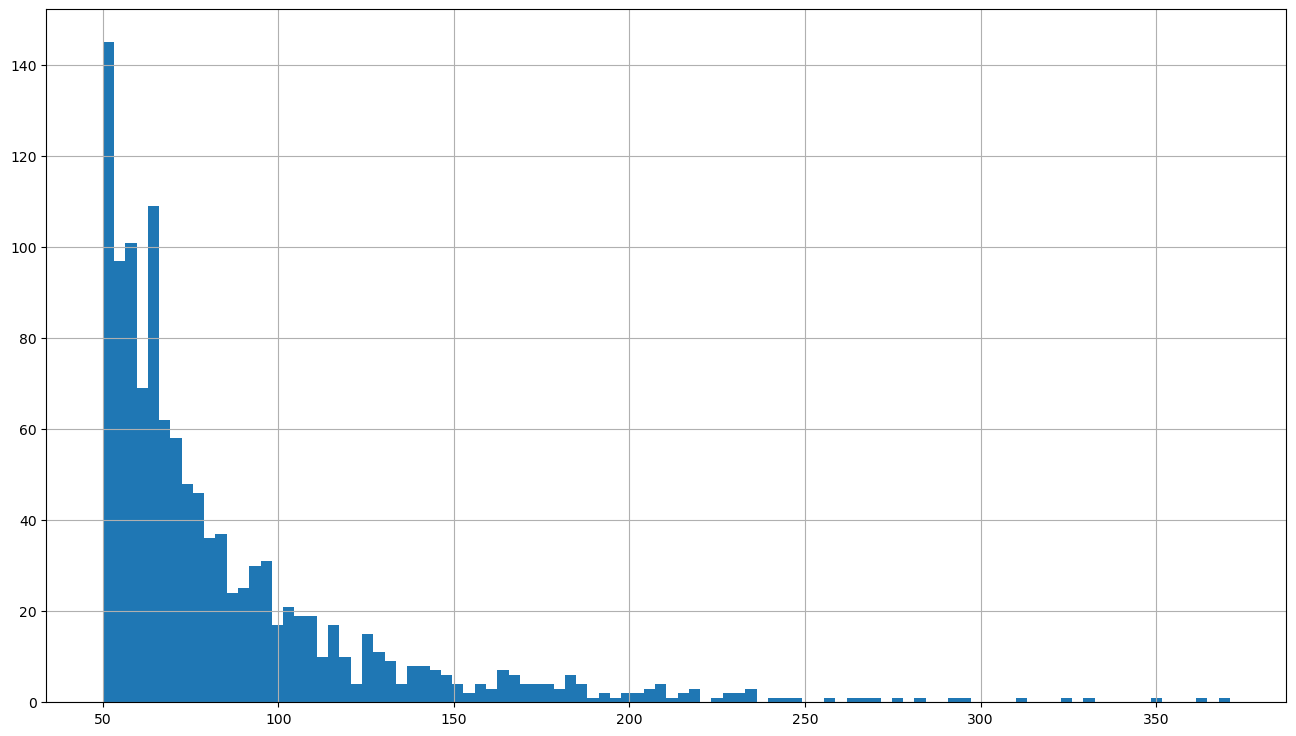

In [48]:
dash_visits.visits.hist(bins=100, range = (50,371) ,figsize=(16,9))

Очевидно, что количество совершенных действий обратно пропроционально количеству таких действий.

По итогам предобработки данных можно сказать, что датафрейм не имеет пустых ячеек, все типы данных корректны, дубликатов нет.<br>
По итогам ознакомления с данными нам удалось посмотреть категории каждого из строчных столбцов и узнать количество каждого значения. Удалось выяснить диапазон времени исследуемых данных. Также удалось рассмотреть зависимость по количеству действий. Все необходимые графики построим позже с помощью tableau. <br>
Настало время экспортировать данные.

In [49]:
dash_visits.to_csv('dash_visits.csv', index=False)

In [50]:
test_visits = pd.read_csv('dash_visits.csv')
test_visits

,record_id,item_topic,source_topic,age_segment,dt,visits
0,1040597,Деньги,Авто,18-25,2019-09-24 18:32:00,3
1,1040598,Деньги,Авто,18-25,2019-09-24 18:35:00,1
2,1040599,Деньги,Авто,18-25,2019-09-24 18:54:00,4
3,1040600,Деньги,Авто,18-25,2019-09-24 18:55:00,17
4,1040601,Деньги,Авто,18-25,2019-09-24 18:56:00,27
...,...,...,...,...,...,...
30740,1071337,Юмор,Финансы,36-40,2019-09-24 18:57:00,2
30741,1071338,Юмор,Финансы,36-40,2019-09-24 19:00:00,1
30742,1071339,Юмор,Финансы,41-45,2019-09-24 18:54:00,1
30743,1071340,Юмор,Финансы,41-45,2019-09-24 18:56:00,1


Отлично, данные успешно выгружены и собраны с csv файл

Ссылка на дашборд: https://public.tableau.com/app/profile/mikhail.gantsel/viz/Yandex_dzen_analysis/sheet0?publish=yes